# 0 Imports

In [1]:
import math
import numpy               as np
import pandas              as pd
import datetime
import random
import pickle
import warnings
import inflection
import seaborn             as sns
import xgboost             as xgb

from scipy                 import stats        as ss
from boruta                import BorutaPy
from matplotlib            import pyplot       as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso, SGDRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

### 0.1.1 Categorical Attributes

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### 0.1.2 Models Performance

In [3]:
## Accuracy Measures

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs(( y - yhat ) / y))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index =[0])
## Cross-Validation

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                      'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                      'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                      'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

### 0.1.3 Graphics

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1 Data Description

In [6]:
df1 = df_raw.copy()

In [7]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1 Data Dictionary

| The data set used is from Kaggle (https://www.kaggle.com/c/rossmann-store-sales)



|Feature                                       |Description   
|:---------------------------|:---------------
| **Store**                         |  Unique Id for each store   | 
| **Sales**                       | Turnover for any given day  | 
| **Customers**                         |  Number of customers on a given day | 
| **Open**                         |  Indicator for whether the store was open: 0 = closed, 1 = open   | 
| **StateHoliday**                          | Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = Public holiday, b = Easter holiday, c = Christmas, 0 = None| 
| **SchoolHoliday**                        | Indicates if the (Store, Date) was affected by the closure of public schools| 
| **StoreType**                    | Differentiates between 4 different store models: a, b, c, d| 
| **Assortment**                       | Describes an assortment level: a = basic, b = extra, c = extended | 
| **CompetitionDistance**                    | Distance in meters to the nearest competitor store| 
| **CompetitionOpenSince[Month/Year]**                    | Gives the approximate year and month of the time the nearest competitor was opened| 
| **Promo**                    | Indicates whether a store is running a promo on that day| 
| **Promo2**                    | A continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating| 
| **Promo2Since[Year/Week]**                    | Describes the year and calendar week when the store started participating in Promo2| 
| **PromoInterval**                    | The consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store| 

## 1.2 Rename Columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.3 Data Dimensions

In [10]:
print ('Number of Rows: {}'.format( df1.shape[0]))
print ('Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.4 Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
#change date from object to datetime
df1['date'] = pd.to_datetime( df1['date'])

## 1.5 Missing Values

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6 Fillout Missing Values (NA)

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance - Blank either because there is no competitors or they are too far to be considered competitors. I will use a big value to disclose the inexistance of competitors.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 100000.0 if math.isnan(x) else x)

#competition_open_since_month - Same rational used as in previous feature, the date of the store will be used as competitors open since date.  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
               
#promo_interval  
    # Map to convert number into name
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }
    # Fill with 0 so it does not compare with 'NaN'
df1['promo_interval'].fillna(0, inplace=True)
    # Extract the month of date and apply the month map to translate it
df1['month_map'] = df1['date'].dt.month.map(month_map)
    # Check if the month_map matches with the promo interval to understand if the promotion is happening (1) or not (0)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.7 Change Types

In [17]:
# changing data types from float to int64

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.8 Descriptive Statistics

In [18]:
# Split numerical and categorical features
num_attributes = df1.select_dtypes( include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

###  1.8.1 Numerical Attributes

In [19]:
#Central Tendency - mean, meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


**Store** Rossmann holds 1.115 physical stores 

**Sales** Daily store turnover ranges from 0 to 41.551€ , average being close to 5.773€

**Customers** Number of customers on a unique day ranges from 0 to 7.388, average being 633

###  Categorical Attributes

In [20]:
# add percentage of most common attribute
cat_attributes_p = cat_attributes.describe().T
cat_attributes_p['freq_p'] = cat_attributes_p['freq'] / cat_attributes_p['count']
cat_attributes_p

,count,unique,top,freq,freq_p
state_holiday,1017209,4,0,986159,0.969475
store_type,1017209,4,a,551627,0.542295
assortment,1017209,3,a,537445,0.528353
promo_interval,1017209,4,0,508031,0.499436
month_map,1017209,12,May,103695,0.101941


**Store Type** 'a' represents ≈ 54% of total stores

**Assortment** 'a' represents ≈ 53% of total stores

# 2 Feature Engineering

In [21]:
df2 = df1.copy()

## 2.2 Hypothesis Formulation

### 2.2.1 Customers

**1.** Older Customers should spend more

**2.** Customers with higher houselhold numbers should spend more

**3.** Customers with a BMI higher than 25 should spend more

**4.** Customers with a BMI lower than 18 should spend more

**5.** Married customers should spend more

**6.** Customers with health insurance should buy more

**7.** Customers with risky occupations should buy more


### 2.2.5 Stores

**1.** Stores placed on market for longer should sell more

**2.** Stores with closer competitions should sell less

**3.** Stores with longer discount campaigns should sell more 

**4.** Stores open on Christmas should sell more

**5.** Stores should sell more after the 10th of each month

**6.** "Extended" assortment stores should sell more

**7.** Smaller stores should sell less

**8.** Stores in urban areas should sell more

**9.** Stores with competitors opened for longer should sell more

**10.** Smaller stores should sell less

**11.** Stores with more promo days should sell more

**12.** Stores with consecutive promotions should more

**13.** Stores should sell more on weekends

## 2.3 Final List of Hypothesis

## 2.4 Feature Creation

In [23]:
# year
df2['year']= df2['date'].dt.year

#month
df2['month']= df2['date'].dt.month

#day
df2['day']= df2['date'].dt.day

#week of year
df2['week_of_year']= df2['date'].dt.weekofyear

#year week
df2['year_week']= df2['date'].dt.strftime( '%Y-%W' )

In [24]:
# competition since - date format of when competition opened
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
# competition_time_month - time in months since competition is open
df2['competition_time_month'] = (( df2['date'] - df2['competition_since']  ) /30 ).apply( lambda x: x.days).astype(int)

# promo since - date format of when promo started
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime ( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
# promo_time_week - time in months since promo started
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'] ) / 7).apply( lambda x: x.days ).astype (int)

In [25]:
# 'is_promo' - describes if the date represented is part of promo or not
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 2.5 Feature Modification

In [26]:
# assortment - change values to descriptive values
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

# state holidays - change values to descriptive values
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [27]:
df2.tail(20).T

,1017189,1017190,1017191,1017192,1017193,1017194,1017195,1017196,1017197,1017198,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
date,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,0,5961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
customers,0,1405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
open,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
promo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
state_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday
school_holiday,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
store_type,a,b,a,a,a,d,a,d,d,c,a,a,a,c,c,a,c,a,a,d


# 3 Data Filtering

In [28]:
df3 = df2.copy()

## 3.1 Rows Filtering

In [29]:
# filter based on open days in which sales were made
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]  

## 3.2 Columns Selection

In [30]:
# customers droped as its not part of the predicted dataset. open dropped as open is now always = 1. The other 2 features will be droped as they were useful exclusively to derive new features.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4 Exploratory Data Analysis (EDA)

In [31]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

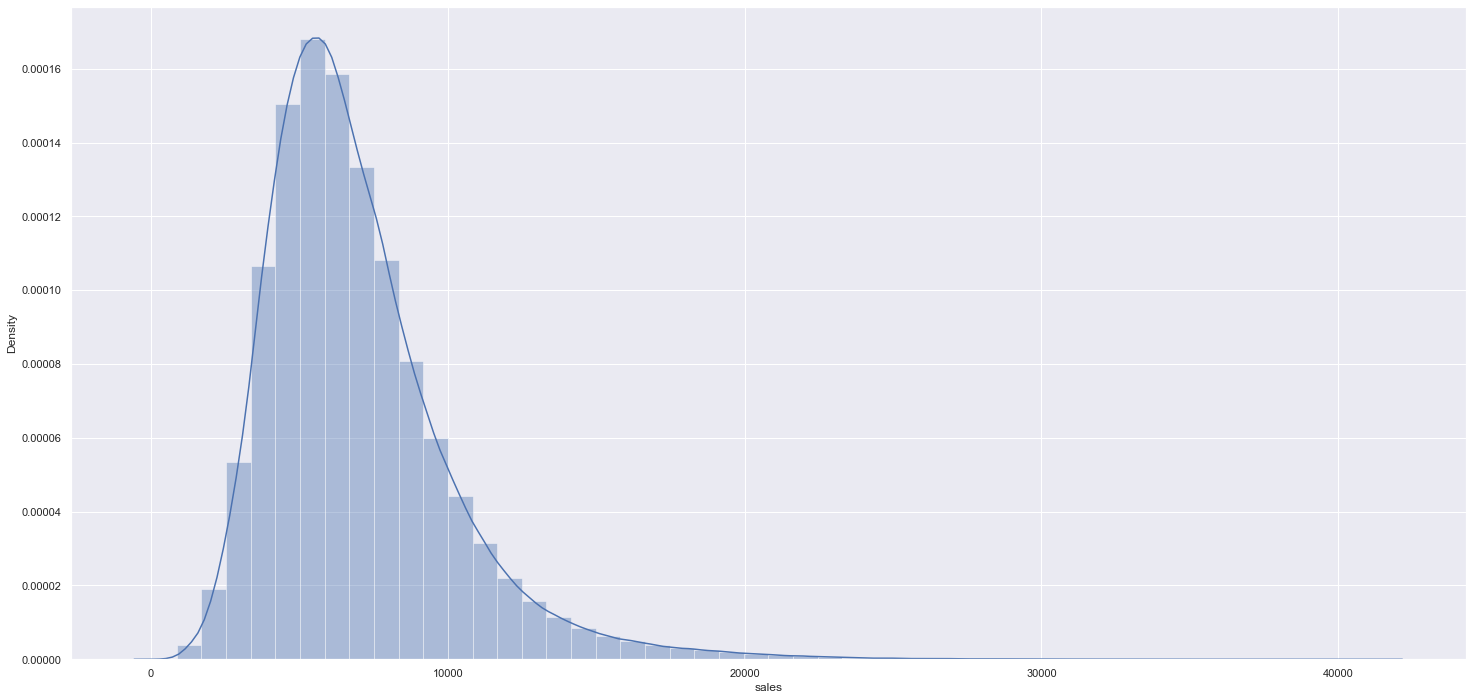

In [32]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable

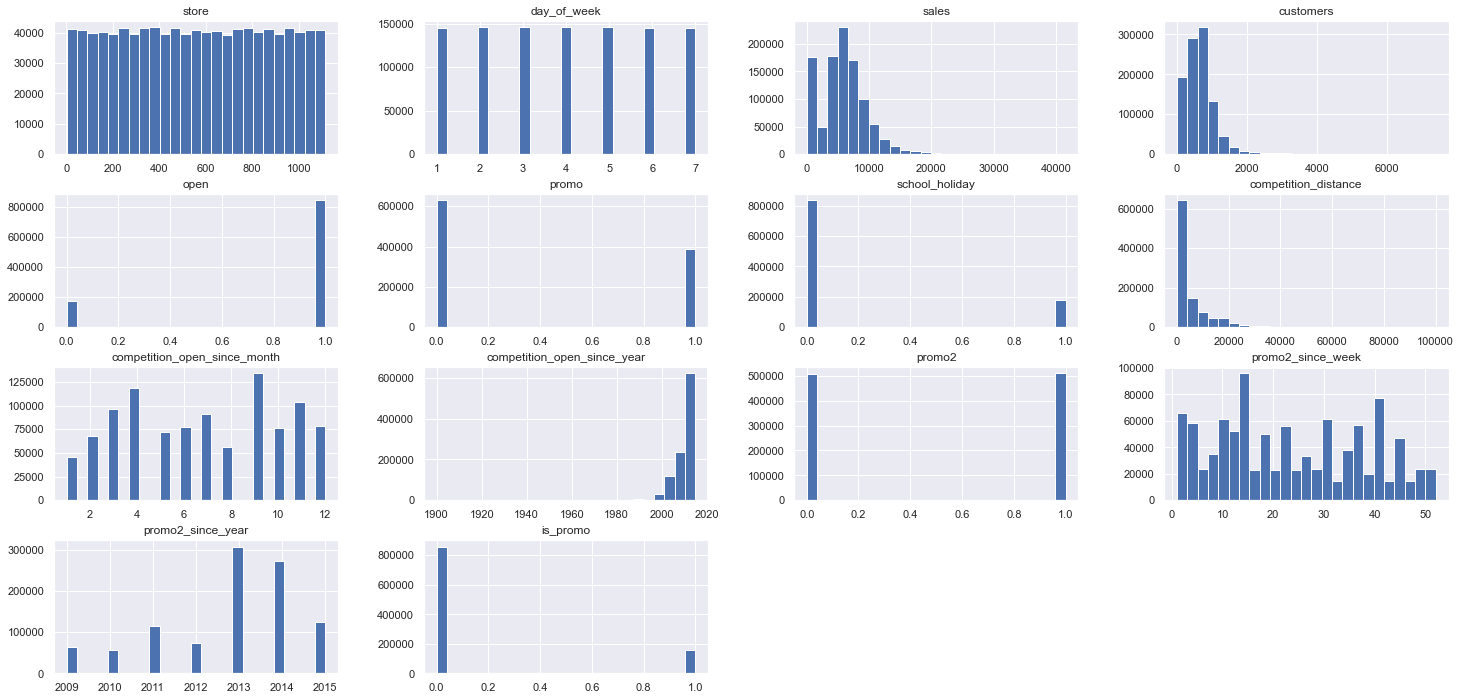

In [33]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

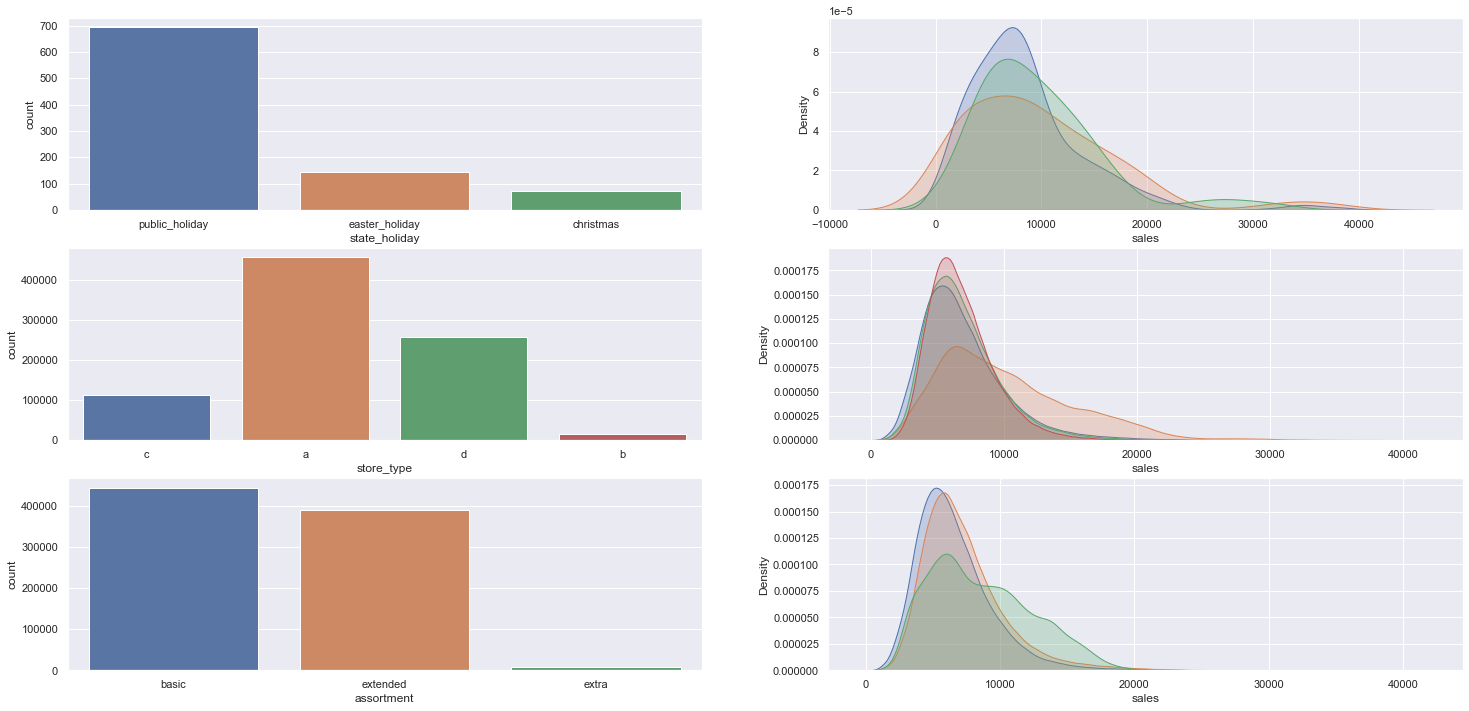

In [34]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2 Bivariate Analysis

### 4.2.1 H1. Stores placed on market for longer should sell more
**False** hypothesis

In [35]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).mean().reset_index()
aux1.head()

,year,sales
0,2013,6814.775168
1,2014,7026.128505
2,2015,7088.235123


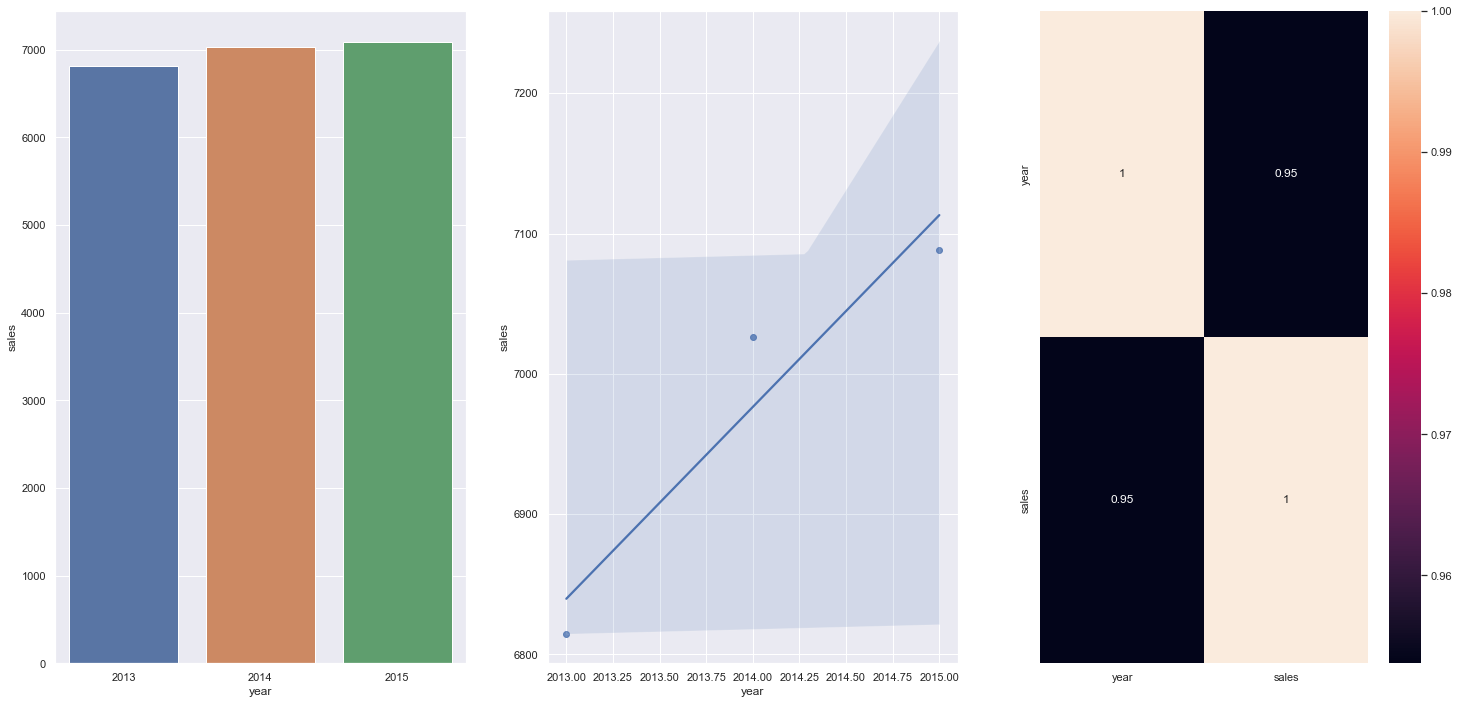

In [36]:
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.2 H2. Stores with closer competitions should sell less
**False**, Hypothesis

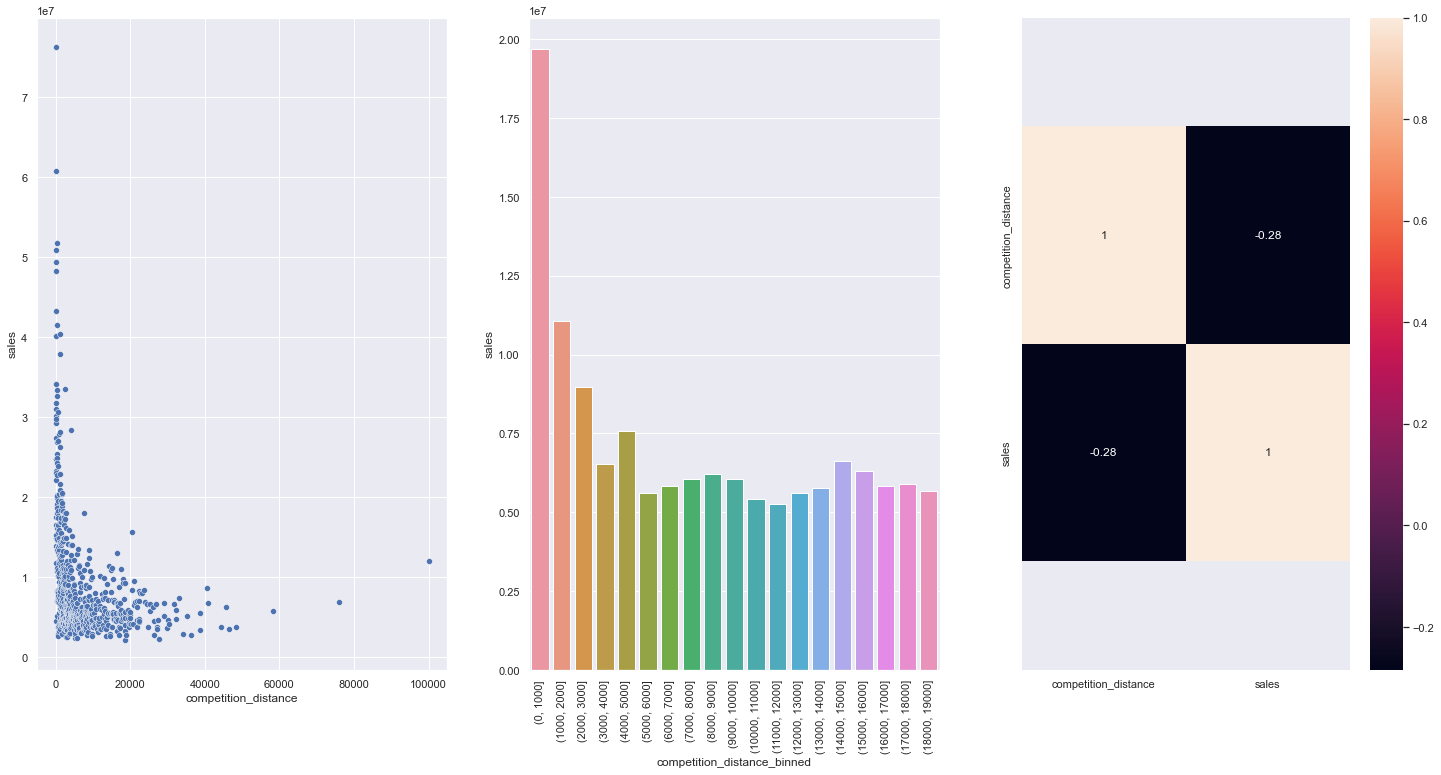

In [37]:
aux21 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux21 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux21['competition_distance_binned'] = pd.cut( aux21['competition_distance'], bins=bins )
aux22 = aux21[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux22 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux21.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### 4.2.3 H3. Stores with longer discount campaigns should sell more 
**False**, Hypothesis

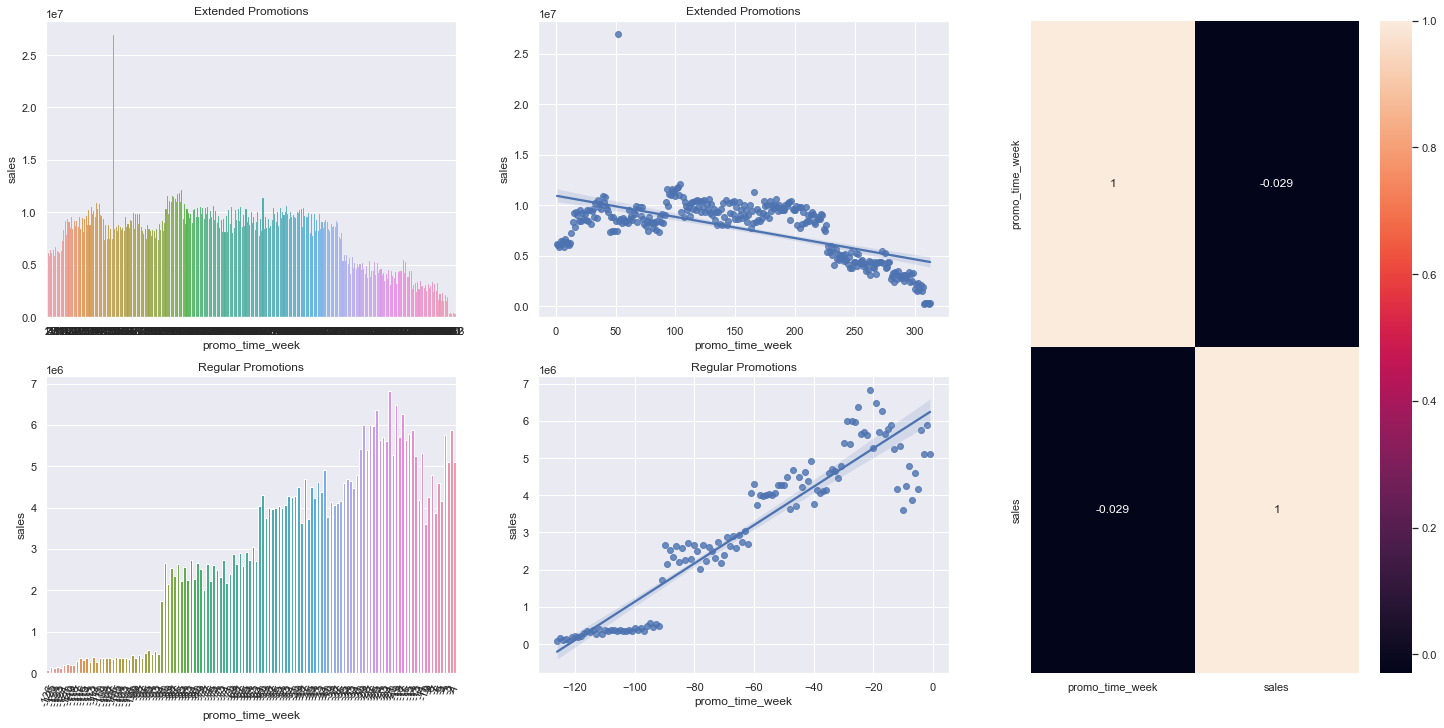

In [38]:
aux231 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux232 = aux231[aux231['promo_time_week'] > 0] # extended promotions
sns.barplot( x='promo_time_week', y='sales', data=aux232, linewidth = 0.1 ).set_title ("Extended Promotions")

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux232 ).set_title ("Extended Promotions")

plt.subplot( grid[1,0] )
aux233 = aux231[aux231['promo_time_week'] < 0] # one off promotions
sns.barplot( x='promo_time_week', y='sales', data=aux233 ).set_title ("Regular Promotions");
plt.xticks( rotation=70 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux233 ).set_title ("Regular Promotions");

plt.subplot( grid[:,2] )
sns.heatmap( aux231.corr( method='pearson' ), annot=True );

### 4.2.4 H4. Stores open on Christmas should sell more
**True**, Hypothesis

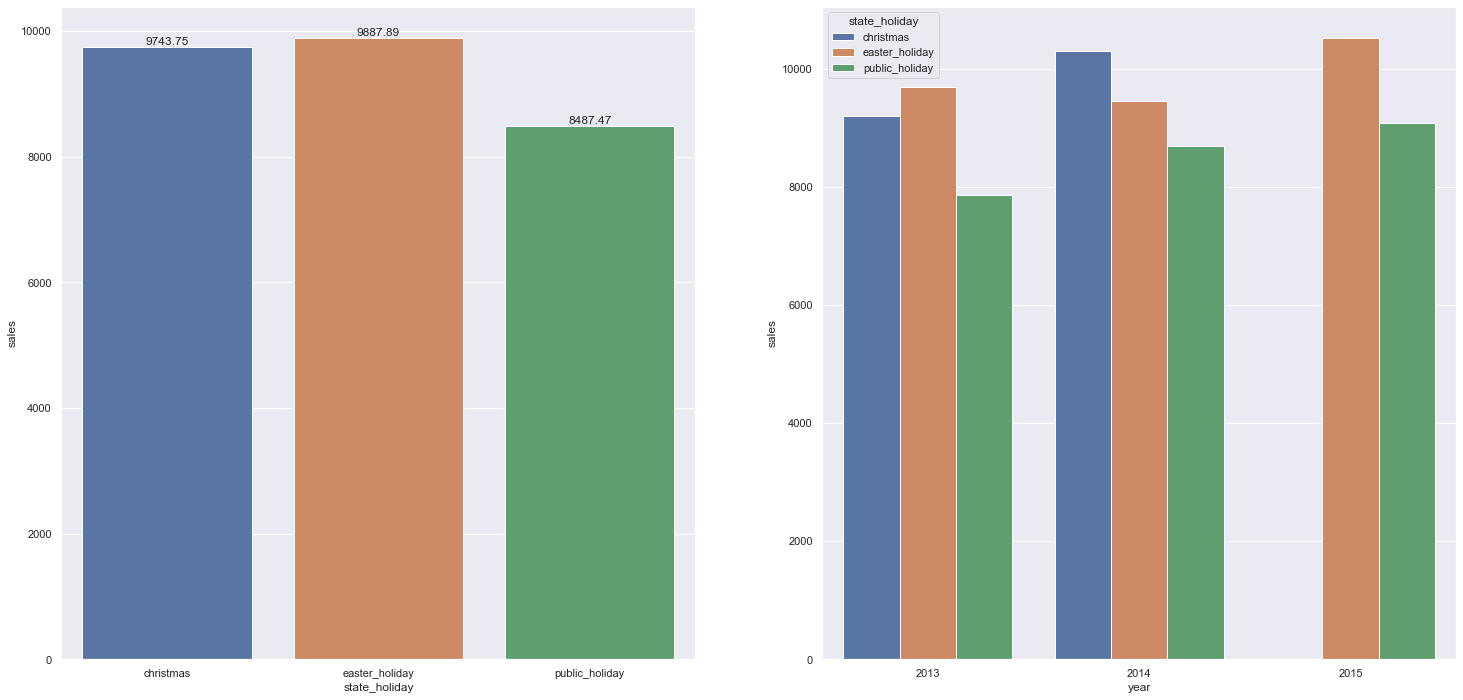

In [39]:
aux241 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux242 = aux241[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
ax241 = sns.barplot( x='state_holiday', y='sales', data=aux242 )
ax241.bar_label(ax241.containers[0])

plt.subplot( 1, 2, 2 )
aux243 = aux241[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux243 );

In [40]:
aux242

,state_holiday,sales
0,christmas,9743.746479
1,easter_holiday,9887.889655
2,public_holiday,8487.471182


### 4.2.5 H5. Stores should sell more after the 10th of each month
**False**, Hypothesis

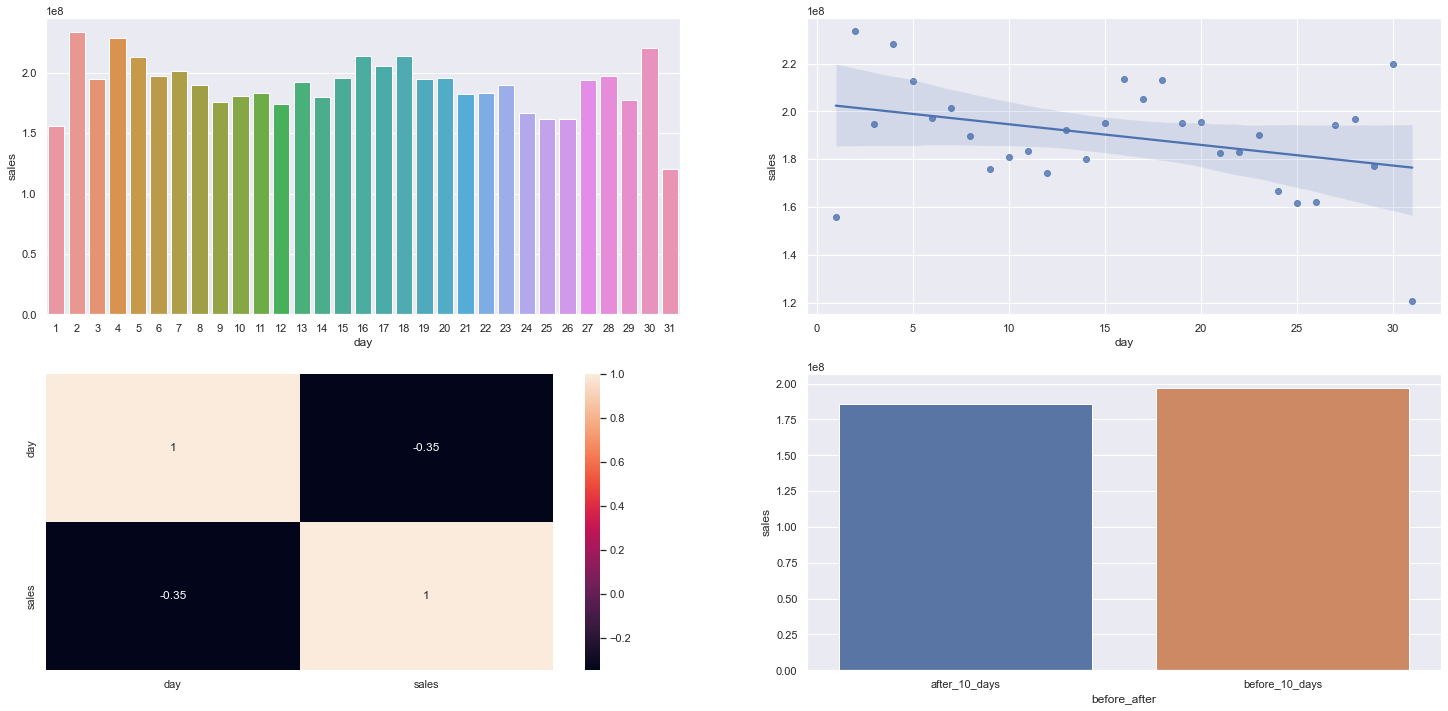

In [41]:
aux251 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux251 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux251 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux251.corr( method='pearson' ), annot=True );
aux251['before_after'] = aux251['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux252 =aux251[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux252 );

### 4.2.6  H6. "Extended" assortment stores should sell more
**False**, Hypothesis

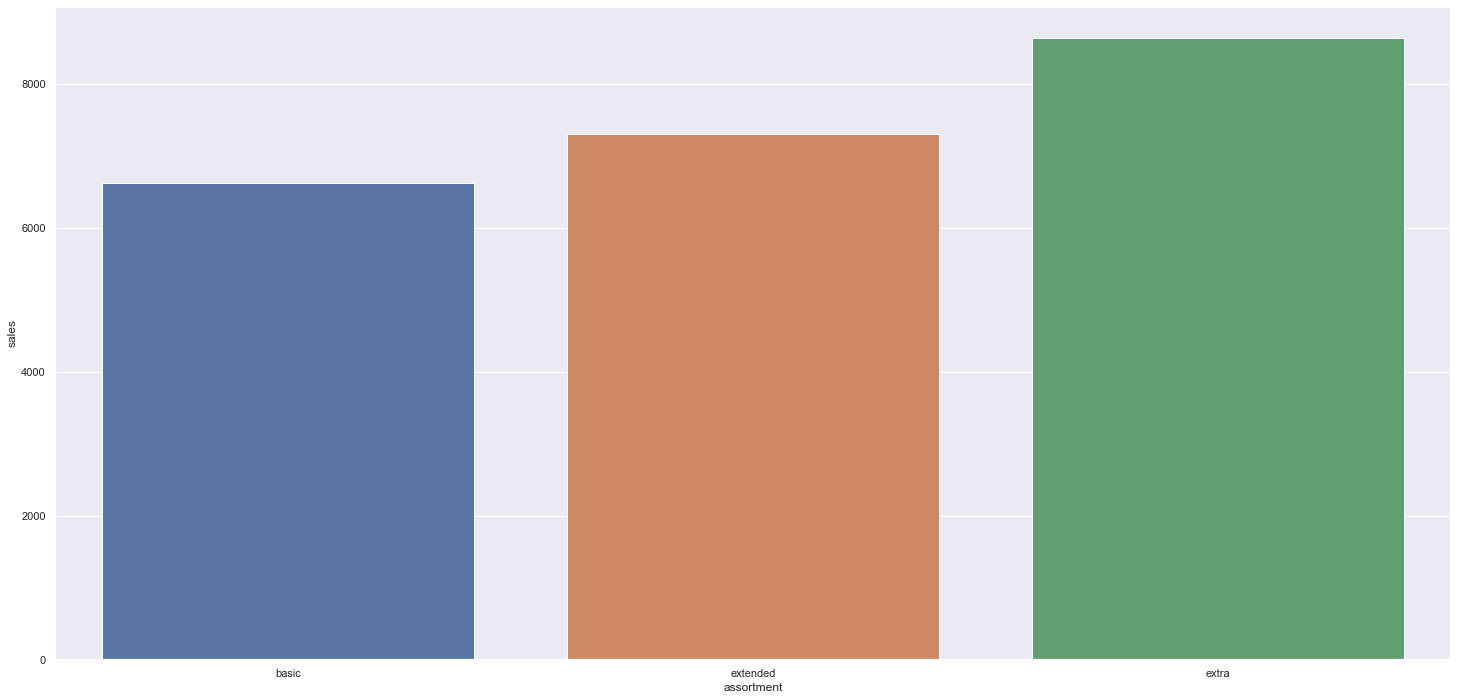

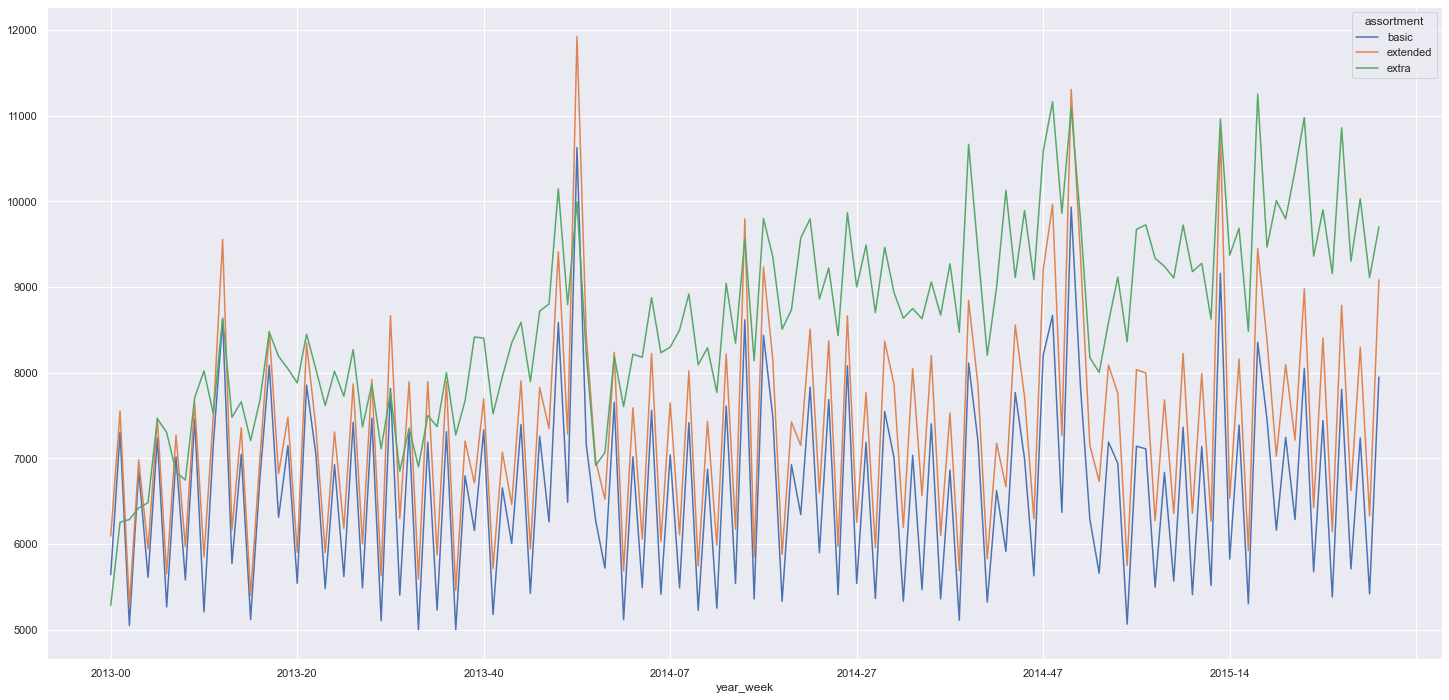

In [42]:
aux261 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()

sns.barplot( x='assortment', y='sales', data=aux261 );

aux262 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).mean().reset_index()
aux262.pivot( index='year_week', columns='assortment', values='sales' ).plot();

In [43]:
aux261

,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


### 4.2.7 H7. Stores with competitors opened for longer should sell more
**True**, Hypothesis

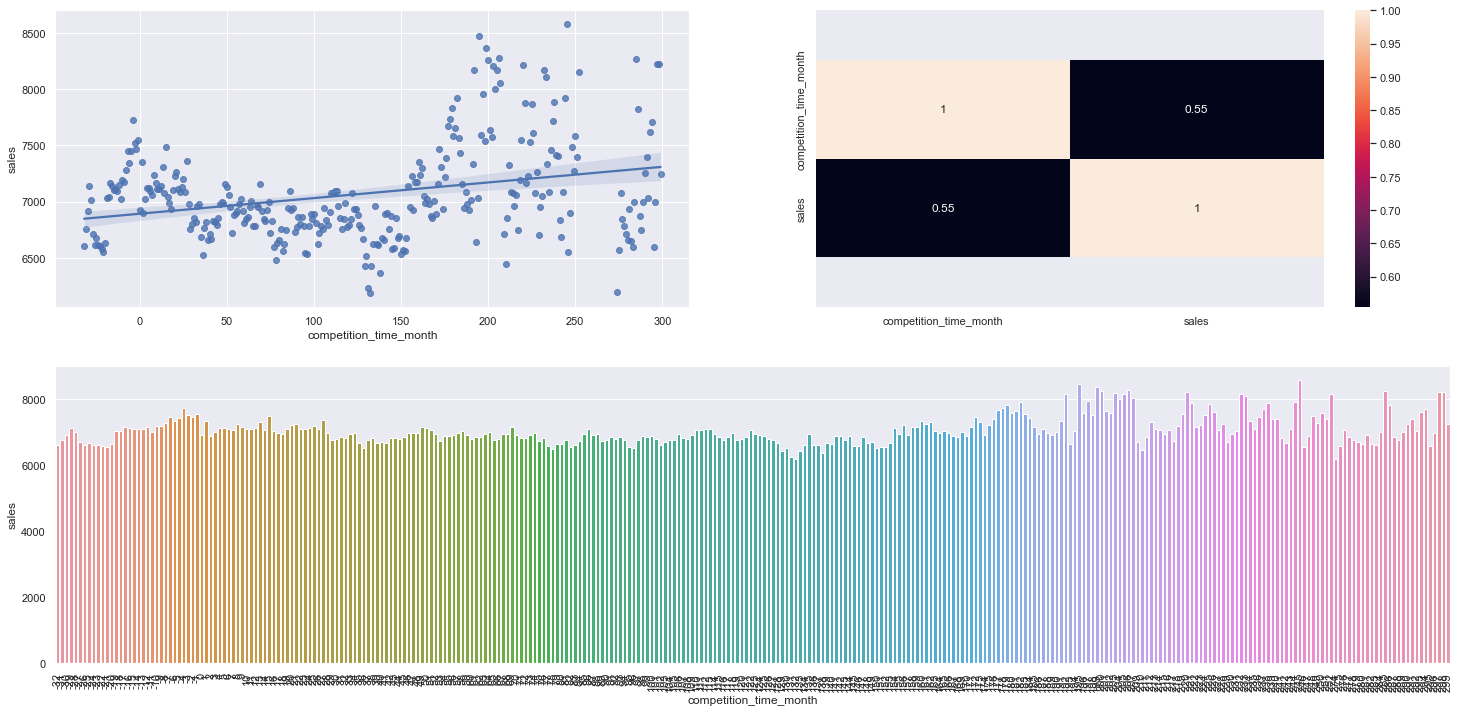

In [44]:
aux271 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).mean().reset_index()

#I will select everything under 300, as based on statistics I have noticed that data ranged between 300-1400 are outliers
plt.subplot( 2, 1, 2 )
aux272 = aux271[( aux271['competition_time_month'] < 300 )]
sns.barplot( x='competition_time_month', y='sales', data=aux272 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 1 )
sns.regplot( x='competition_time_month', y='sales', data=aux272 );

plt.subplot( 2, 2, 2 )
x = sns.heatmap( aux271.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### 4.2.8 H8. Stores with consecutive promotions should sell more
**False**, Hypothesis

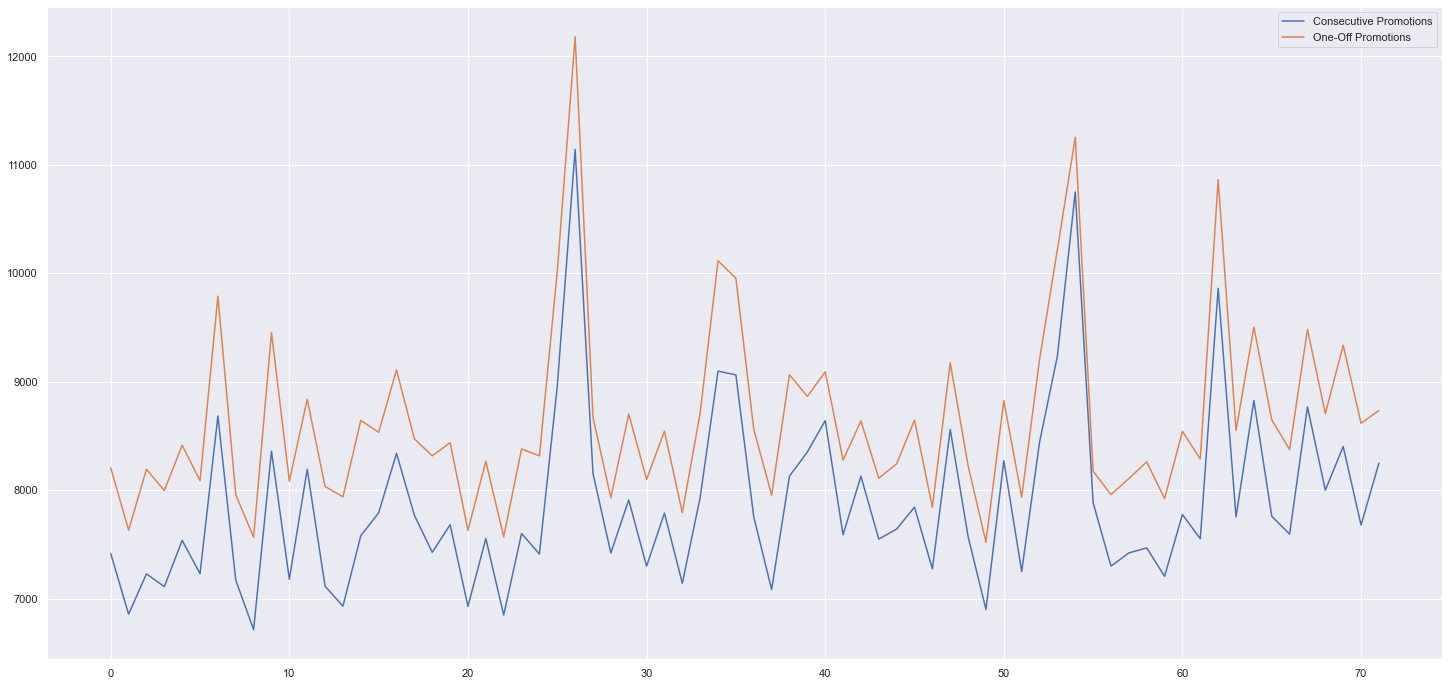

In [45]:
aux281 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
ax281 = aux281.plot()

aux282 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
aux282.plot( ax=ax281 )
ax281.legend( labels=['Consecutive Promotions', 'One-Off Promotions']);

In [46]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


### 4.2.9 H9. Stores should sell more on weekends
**False**, Hypothesis

In [47]:
df4['group'] = df4['day_of_week'].apply( lambda x: 'working_days' if x <= 5 else 'weekends' )
aux291 =df4[['group', 'sales']].groupby( 'group' ).mean().reset_index()
aux291

,group,sales
0,weekends,5932.264337
1,working_days,7172.903208


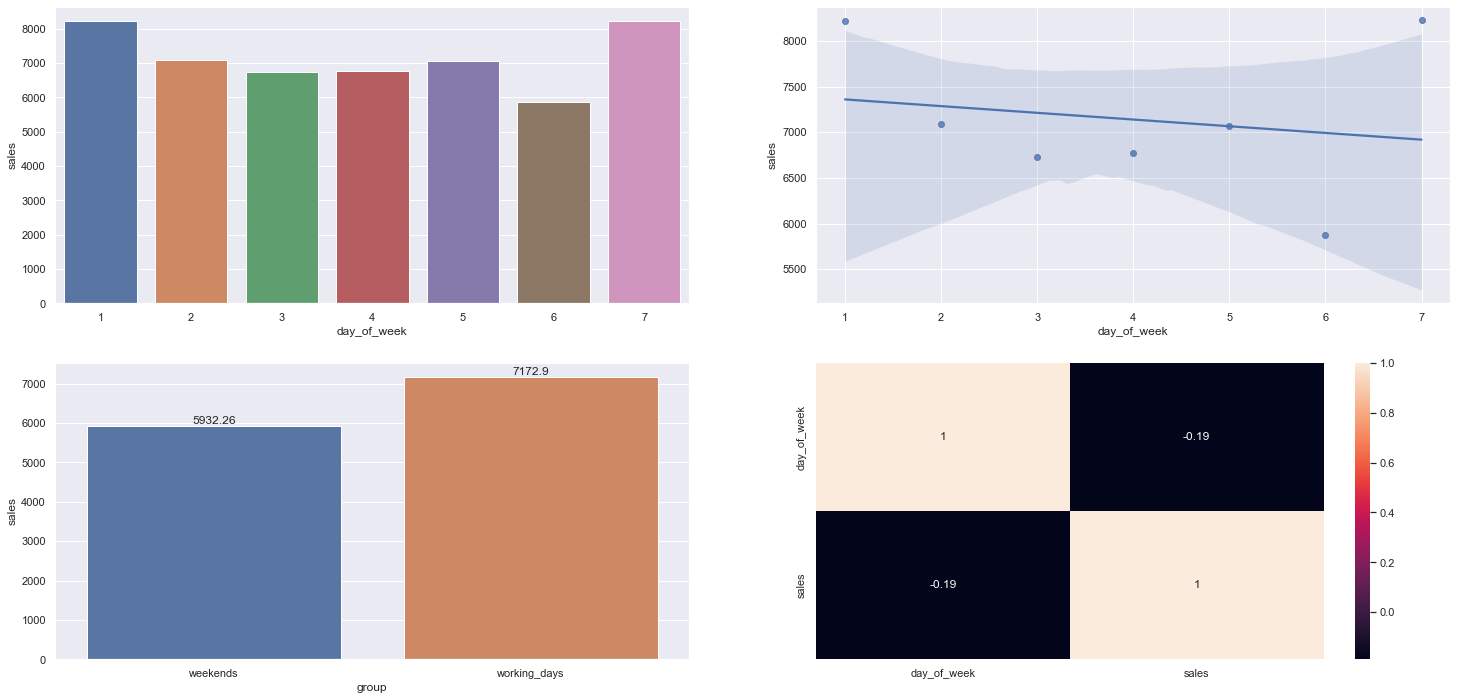

In [48]:
aux292 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux292 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux292 );

plt.subplot( 2, 2, 3 )
ax291 = sns.barplot( x='group', y='sales', data=aux291 );
ax291.bar_label(ax291.containers[0]);

plt.subplot( 2, 2, 4 )
sns.heatmap( aux292.corr( method='pearson' ), annot=True );

## 4.3 Multivariable Analysis


### 4.3.1 Numerical Variable
**Finding** Having the target variable in scope, the stronger correlations are 'customers' (0.89), 'open' (0.68), 'day_of_week' (-0.46) and 'promo' (0.45). Outside the target variable scope, between 'day of week' and 'open' there is a negative correlation of -0.53, 'day_of_week' and 'customers' there is -0.39. Between 'promo' and 'customers' there is a positive correlation of 0.32, finally between 'promo' and 'open' there is 0.30.

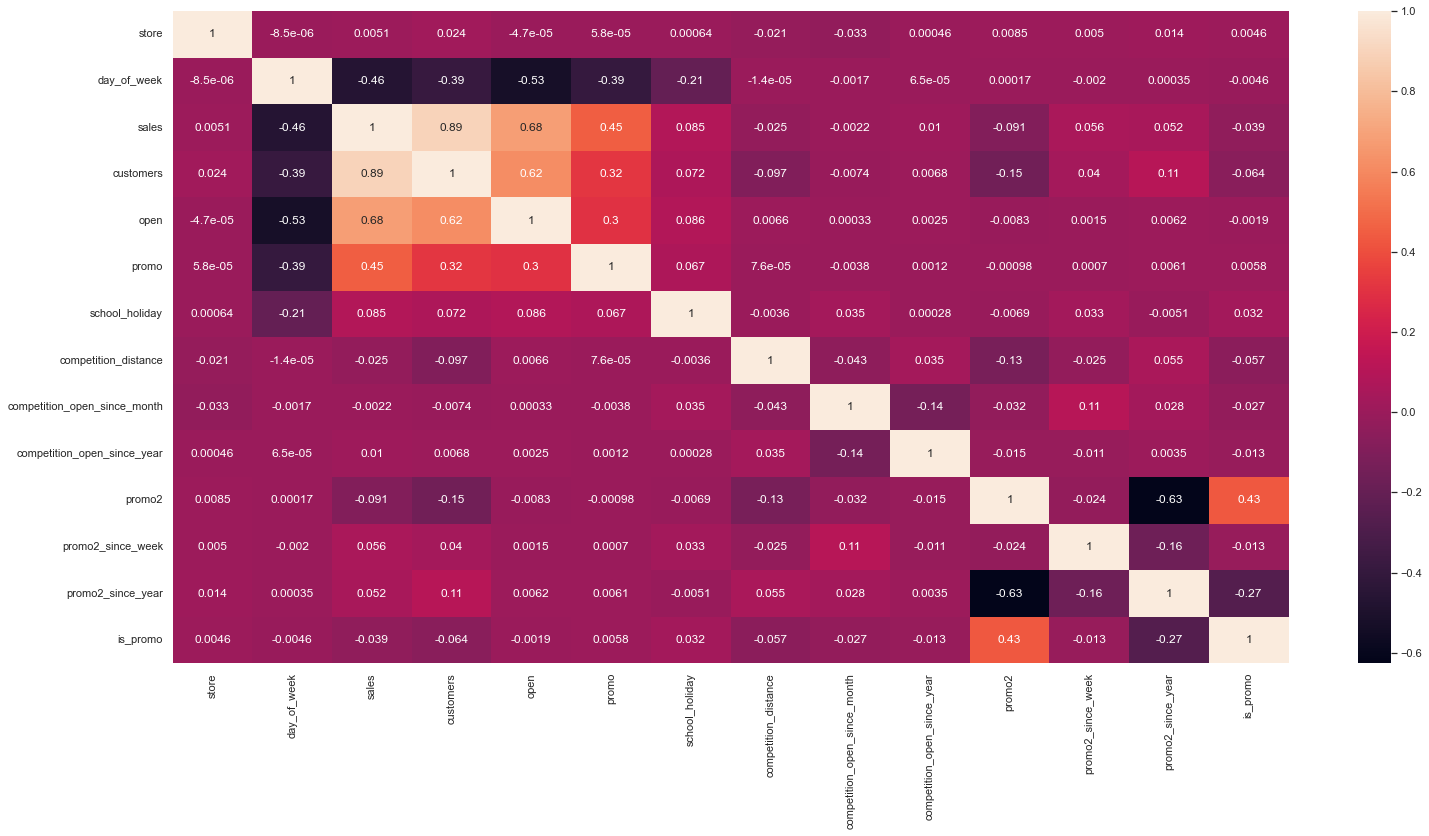

In [49]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes
**Finding** The most noticeable correlation is found between 'assortment' and 'store_type' with a negative correlation of 0.54

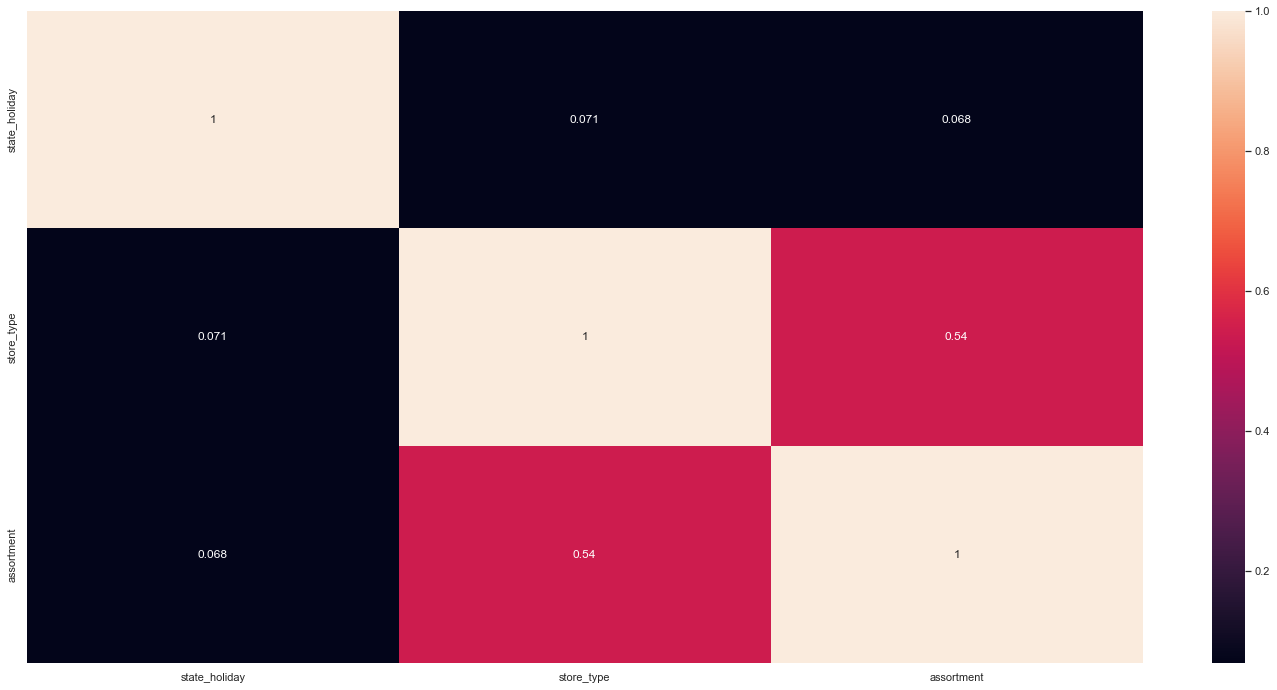

In [50]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5 Data Preparation

In [32]:
df5 = df4.copy()

## 5.1 Rescaling

In [33]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump (rs, open('parameter/scaler_competition_distance.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump (rs, open('parameter/scaler_competition_time_month.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump (rs, open('parameter/scaler_promo_time_week.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump (mms, open('parameter/scaler_year.pkl', 'wb'))

## 5.2 Transformation

### 5.2.1 Encoding

In [34]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump (le, open('parameter/scaler_store_type.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.2.2 Response Variable Transformation

In [35]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.2.3 Nature Transformation

In [36]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

# 6 Feature Selection

In [37]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [39]:
## Drop columns that are not necessary for modeling stage. 
# 'week_of_year', 'day', 'month', 'day_of_week' - new features have been created based on this feature, making these no longer needed ( Nature transformation)
# 'promo_since' was used to derive 'promo_time_week' the first feature will be dropped
# 'competition_since' was used to derive 'competition_since_month', the first feature will be dropped
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'group']
df6 = df6.drop( cols_drop, axis=1 )

In [40]:
# Find date that represents 6 weeks cut-off
df6['date'].max() - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [41]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [60]:
## training and test dataset for Boruta

X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

## define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


## 6.3 Best Features from Boruta

### 6.3.1 Selected Features

In [61]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

### 6.3.2 Not Selected Features

In [62]:
#not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.4 Manual Feature Selection

In [42]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7 Machine Learning Modelling 

In [43]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test [ cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


In [66]:
aux1.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,day_sin,day_cos,week_of_year_cos,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.866025,0.207912,0.978148,-0.822984,8.568646,8.373392
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.866025,0.207912,0.978148,-0.822984,8.710290,8.460676
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.866025,0.207912,0.978148,-0.822984,9.025816,8.795885
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.866025,0.207912,0.978148,-0.822984,9.546527,9.194715
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.866025,0.207912,0.978148,-0.822984,8.481151,8.346624


## 7.2 Linear Regression Model

### 7.2.1 Single Performance

In [67]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1873.115897,0.295501,2667.791351


### 7.2.2 Linear Regression Model - Cross Validation

In [68]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr , verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.95 +/- 303.16,0.3 +/- 0.02,2958.57 +/- 473.83


## 7.3 Linear Regression Regularized Model - Lasso

### 7.3.1 Single Performance

In [69]:
# model
lasso = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lasso = lasso.predict(x_test)

# performance
lasso_result = ml_error('Linear Regression Regularized Model - Lasso', np.expm1(y_test), np.expm1(yhat_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1892.731502,0.290042,2741.026697


### 7.3.2 Linear Regression Regularized Model - Lasso - Cross Validation

In [70]:
lasso_result_cv = cross_validation( x_training, 5, 'Lasso', lasso , verbose=False )
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.23 +/- 342.11,0.29 +/- 0.01,3058.18 +/- 504.81


## 7.4 Random Forest Regressor

### 7.4.1 Single Performance

In [71]:
# model
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,731.155675,0.108727,1075.702224


### 7.4.2 Random Forest Regressor - Cross Validation

In [72]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,841.12 +/- 222.98,0.12 +/- 0.02,1259.44 +/- 327.52


## 7.5 XGBoost Regressor

### 7.5.1 Single Performance

In [73]:
# model
xgbr = xgb.XGBRegressor().fit(x_train, y_train)

# prediction
yhat_xgbr = xgbr.predict(x_test)

# performance
xgbr_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgbr))
xgbr_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,908.750984,0.136727,1309.609772


### 7.5.2 XGBoost Regressor - Cross Validation

In [74]:
xgbr_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', xgbr )
xgbr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1096.96 +/- 179.03,0.15 +/- 0.02,1578.28 +/- 246.71


## 7.6 Comparing Models Preformance 

### 7.6.1 Single Performance

In [75]:
models_results = pd.concat([baseline_result, lasso_result, lr_result, rf_result, xgbr_result])
models_results.sort_values('MAPE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,731.155675,0.108727,1075.702224
0,XGBoost Regressor,908.750984,0.136727,1309.609772
0,Linear Regression Regularized Model - Lasso,1892.731502,0.290042,2741.026697
0,Linear Regression,1873.115897,0.295501,2667.791351
0,Average Model,1354.800353,0.455051,1835.135542


### 7.6.2 Real Performance - Cross Validation

In [76]:
models_results_cv = pd.concat([lasso_result_cv, lr_result_cv, rf_result_cv, xgbr_result_cv])
models_results_cv.sort_values('MAPE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,841.12 +/- 222.98,0.12 +/- 0.02,1259.44 +/- 327.52
0,XGBoost Regressor,1096.96 +/- 179.03,0.15 +/- 0.02,1578.28 +/- 246.71
0,Lasso,2117.23 +/- 342.11,0.29 +/- 0.01,3058.18 +/- 504.81
0,Linear Regression,2079.95 +/- 303.16,0.3 +/- 0.02,2958.57 +/- 473.83


# 8 Hyperparameter Fine Tuning

## 8.1 Random Search

In [94]:
import random

param = {'n_estimators': [2500, 3000],
         'subsample': (0.5, 0.6),
         'colsample_bytree': (0.6, 0.7),
         'max_depth': (4, 5),
         'eta': [0.02, 0.03],
         'min_child_weight' : [1 , 2]}

MAX_EVAL = 5

In [97]:
final_result = pd.DataFrame()

for i in range ( MAX_EVAL ):
    
    ## choose randomly values for parameters
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    # model
    model_xgbr = xgb.XGBRegressor(n_estimators = hp['n_estimators'],
                                  subsample = hp['subsample'],
                                  colsample_bytree = hp['colsample_bytree'],
                                  max_depth=  hp['max_depth'],
                                  eta = hp['eta'],
                                  min_child_weight=hp['min_child_weight'])


    # performance
    model_xgb_result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgbr)
    final_result = pd.concat([final_result, model_xgb_result])
    
final_result

{'n_estimators': 3000, 'subsample': 0.5, 'colsample_bytree': 0.7, 'max_depth': 5, 'eta': 0.03, 'min_child_weight': 1}
{'n_estimators': 2500, 'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 4, 'eta': 0.02, 'min_child_weight': 2}
{'n_estimators': 3000, 'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 4, 'eta': 0.03, 'min_child_weight': 2}
{'n_estimators': 3000, 'subsample': 0.5, 'colsample_bytree': 0.6, 'max_depth': 5, 'eta': 0.03, 'min_child_weight': 2}
{'n_estimators': 3000, 'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 4, 'eta': 0.03, 'min_child_weight': 2}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,937.44 +/- 113.26,0.13 +/- 0.01,1341.91 +/- 163.73
0,XGBoost Regressor,1240.63 +/- 133.82,0.17 +/- 0.01,1786.98 +/- 168.17
0,XGBoost Regressor,1066.76 +/- 134.26,0.15 +/- 0.01,1529.85 +/- 182.51
0,XGBoost Regressor,937.73 +/- 117.59,0.13 +/- 0.01,1345.56 +/- 169.7
0,XGBoost Regressor,1066.76 +/- 134.26,0.15 +/- 0.01,1529.85 +/- 182.51


## 8.2 Final Model

In [98]:
param_tuned = {'n_estimators': 3000,
         'subsample': 0.5,
         'colsample_bytree': 0.7,
         'max_depth': 5,
         'eta': 0.03,
         'min_child_weight' : 1}

In [99]:
# model
model_xgb_tuned = xgb.XGBRegressor(n_estimators = param_tuned['n_estimators'],
                                  subsample = param_tuned['subsample'],
                                  colsample_bytree = param_tuned['colsample_bytree'],
                                  max_depth=  param_tuned['max_depth'],
                                  eta = param_tuned['eta'],
                                  min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Save Trained Model
pickle.dump( model_xgb_tuned, open('/Users/User/repos/RossmannSalesPred/model/model.pkl', 'wb'))

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,784.351768,0.119457,1111.65806


# 9 Error Translation and Interpretation

In [100]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [101]:
# sum of predictions
df9_1 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df9_2 = pd.merge( df9_1, df9_aux3, how='inner', on='store' )
# Scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']
# order columns
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [102]:
df9_2.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107737.273438,104330.088482,111144.458393,3407.184956,0.609758
908,909,230742.312500,223074.720236,238409.904764,7667.592264,0.513498
901,902,211643.109375,209920.538746,213365.680004,1722.570629,0.430203
875,876,200991.609375,196994.241402,204988.977348,3997.367973,0.331960
169,170,200921.031250,199593.733022,202248.329478,1327.298228,0.329884


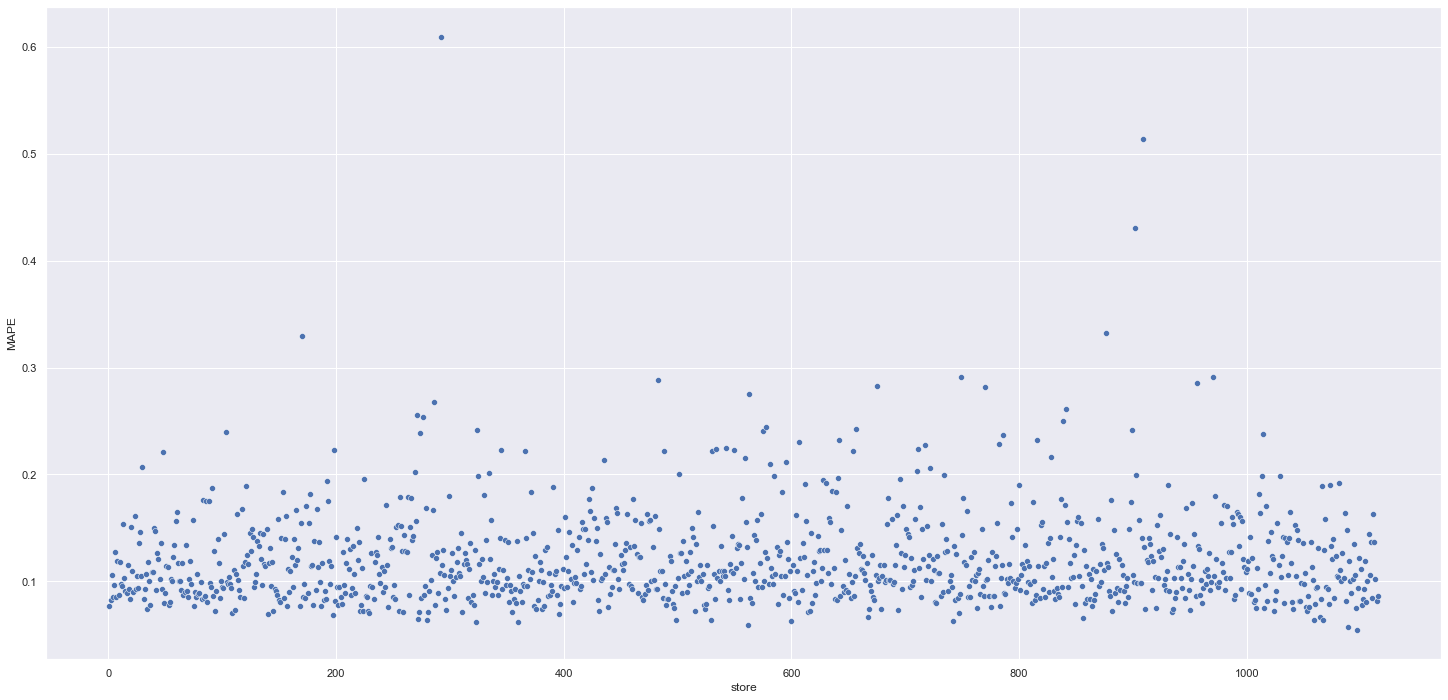

In [103]:
sns.scatterplot( x='store', y='MAPE', data=df9_2 );

## 9.2 Total Performance

In [104]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df9_3['Values'] = df9_3['Values'].map( '€{:,.2f}'.format )
df9_3

,Scenario,Values
0,predictions,"€289,295,552.00"
1,worst_scenario,"€288,417,704.40"
2,best_scenario,"€290,173,376.54"


## 9.3 Machine Learning Performance

In [105]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

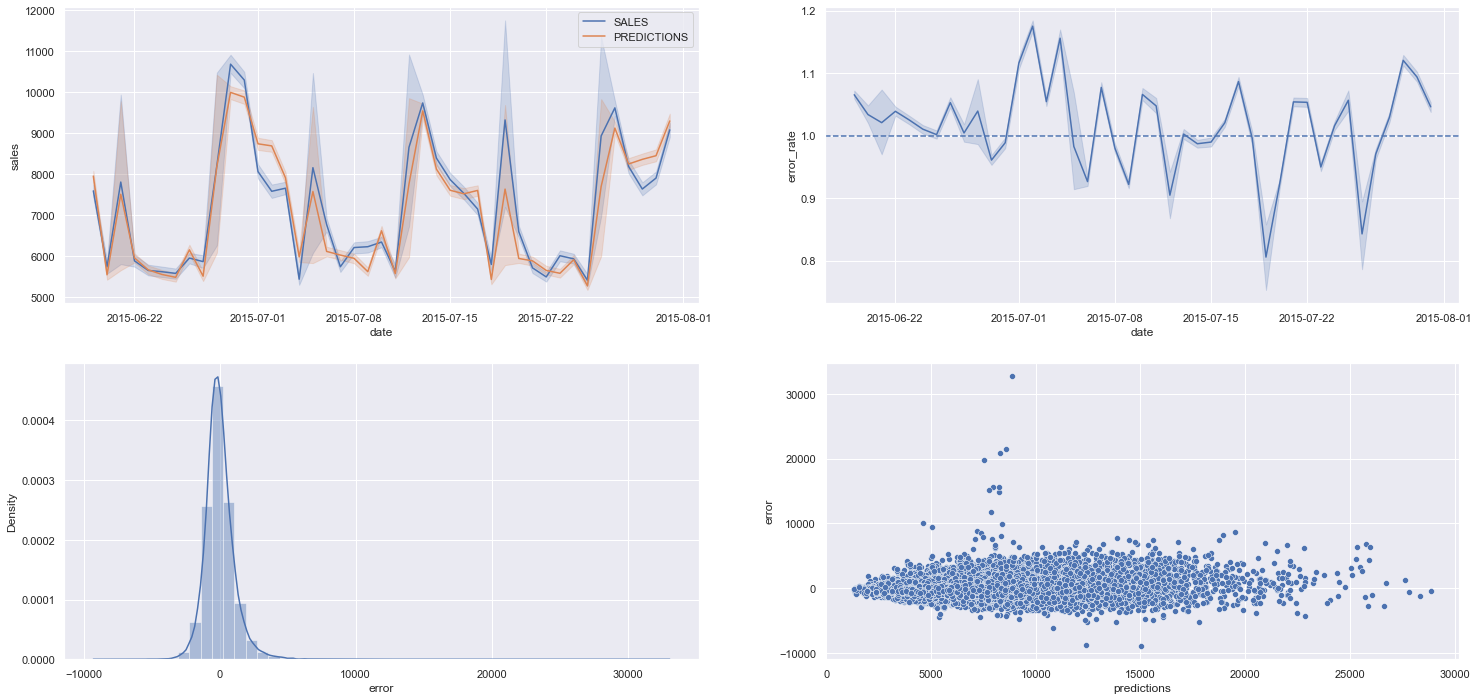

In [106]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

# 10 Model Deploy

## 10 .1 Rossmann Class

In [112]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path=''
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/scaler_competition_distance.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/scaler_competition_time_month.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/scaler_promo_time_week.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/scaler_year.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/scaler_store_type.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.2. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.4. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.6. Fillout Missing Values (NA)
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.7. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0 Data Filtering
        ## 3.1 Rows Filtering
        df2 = df2[df2['open'] != 0]

        ## 3.2 Columns Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.1 Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
 
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.2.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.2.3 Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [ ]:
import os
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'model/model.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( host='0.0.0.0', port=port )

## 10.3 API Tester

In [79]:
# loading test data
df10 = pd.read_csv('/Users/User/repos/RossmannSalesPred/data/test.csv')

In [80]:
#merge test and store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose stores to push prediction
df_test = df_test[df_test['Store'].isin( [22, 10, 12, 99] ) ]

# removed closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1)

In [81]:
# Convert dataframe to Json
data = json.dumps(df_test.to_dict( orient='records'))

In [165]:
import requests
# API Call
# for local machine url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header)
print ( 'Status Code{}'.format(r.status_code) )

Status Code200


In [159]:
#read data
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())
d1.head()

In [161]:
# Translate dataset to business prediciton
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range ( len ( d2 ) ):
    print ( 'Store Number {} will sell {:,.2f}€ in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction']))

Store Number 10 will sell €196,208.53 in the next 6 weeks
Store Number 12 will sell €286,257.50 in the next 6 weeks
Store Number 22 will sell €181,909.70 in the next 6 weeks
Store Number 99 will sell €192,517.90 in the next 6 weeks
